Notebook structure:
- 1. Importing libraries
- 2. Loading the dataset
- 3. Exploratory Data Analysis
- 4. Data Preprocessing
- 5. Model Training
- 6. Model Evaluation

## 1. Importing libraries

In [363]:
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import preprocessing, tree, metrics, model_selection, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, MinMaxScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score

import xgboost as xgb
import tensorflow as tf
import datetime
import random


# Lois
from lois import lois_ds_report
%matplotlib inline

## 2. Loading the dataset

In [364]:
train_data = pd.read_csv('data/training_data.csv')
test_data = pd.read_csv('data/test_data.csv')

# Add a "fake target" column to the test data
test_data['incidents'] = "test-only"

# Concatenate the training and test data
dataset = pd.concat([train_data, test_data], axis=0)

## 3. Exploratory Data Analysis

╭─────────────────────────────────────────── Exploratory Data Anlysis ────────────────────────────────────────────╮
│                                                                                                                 │
╰──────────────────────────────────── EDA|simple| Suitable for data scientist ────────────────────────────────────╯

Shape Analysis
┗━━ Dataset Shape Analysis
    ┣━━ Dataset head
    ┣━━ General info 
    ┣━━ The target variable
    ┣━━ Number of rows and columns
    ┣━━ The different data types
    ┃   ┣━━ The sum of different variable type
    ┃   ┗━━ Visual representation of different variable type
    ┗━━ Analyze missing value
        ┣━━ The percentage of missing value in each columns
        ┣━━ The missing value counts
        ┗━━ Visual representation of missing value

╭──────────────────────────────────────────── DATASET SHAPE ANALYSIS ─────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

-------------------- THE HEAD OF YOUR DATASET --------------------

Your dataset is too large ; only the first 8 columns will be display

                                                    The Dataset                                                    
┏━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ city… ┃ magnitude_of_… ┃ delay_in_se… ┃ affected_… ┃ record… ┃ lumin… ┃ avg_tempera… ┃ avg_atm_pre… ┃ avg_humi… ┃
┡━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
└───────┴────────────────┴──────────────┴────────────┴─────────┴────────┴──────────────┴──────────────┴───────────┘

-------------------- SOME GENERAL INFO ABOUT YOUR DATASET --------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6206 entries, 0 to 1205
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city_name           6206 non-null   object 
 1   magnitude_of_delay  6206 non-null   object 
 2   delay_in_seconds    6206 non-null   int64  
 3   affected_roads      6099 non-null   object 
 4   record_date         6206 non-null   object 
 5   luminosity          6206 non-null   object 
 6   avg_temperature     6206 non-null   float64
 7   avg_atm_pressure    6206 non-null   float64
 8   avg_humidity        6206 non-null   float64
 9   avg_wind_speed      6206 non-null   float64
 10  avg_precipitation   6206 non-null   float64
 11  avg_rain            6206 non-null   object 
 12  incidents           6206 non-null   object 
dtypes: float64(5), int64(1), object(7)
memory usage: 678.8+ KB


-------------------- THE TARGET VARIABLE OF YOUR DATASET --------------------

╭───────────────────────────────────────╮
│ The Target variable is : 'incidents'  │
╰───────────────────────────────────────╯

-------------------- ROWS AND COLUMNS IN YOUR DATASET --------------------

╭─ Shape output ─╮
│ (6206, 13)     │
╰────────────────╯

╭────────────────────────────────────────────────╮
│ Your dataset contains 6206 Rows and 13 Columns │
╰────────────────────────────────────────────────╯

-------------------- THE DATA TYPES IN YOUR DATASET --------------------

╭─ Data types output ─╮
│ object     7        │
│ float64    5        │
│ int64      1        │
│ dtype: int64        │
╰─────────────────────╯

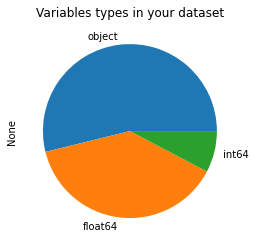

-------------------- MISSING VALUE IN YOUR DATASET --------------------

╭───── Missing value output ─────╮
│ city_name             0.000000 │
│ magnitude_of_delay    0.000000 │
│ delay_in_seconds      0.000000 │
│ record_date           0.000000 │
│ luminosity            0.000000 │
│ avg_temperature       0.000000 │
│ avg_atm_pressure      0.000000 │
│ avg_humidity          0.000000 │
│ avg_wind_speed        0.000000 │
│ avg_precipitation     0.000000 │
│ avg_rain              0.000000 │
│ incidents             0.000000 │
│ affected_roads        0.017241 │
│ dtype: float64                 │
╰────────────────────────────────╯

╭─ Missing value counts output ─╮
│ 0.017241     1                │
│ 0.000000    12                │
│ dtype: int64                  │
╰───────────────────────────────╯

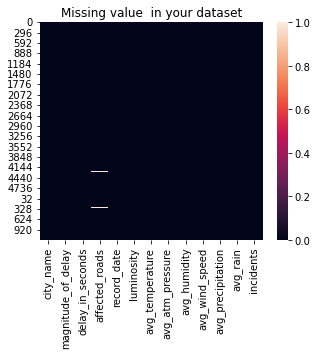

#################### END ####################

In [365]:
lois_ds_report(dataset,target_variable="incidents")

In [366]:
dataset.head()

,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain,incidents
0,Guimaraes,UNDEFINED,0,",",2021-03-15 23:00,DARK,12.0,1013.0,70.0,1.0,0.0,Sem Chuva,None
1,Guimaraes,UNDEFINED,385,"N101,",2021-12-25 18:00,DARK,12.0,1007.0,91.0,1.0,0.0,Sem Chuva,None
2,Guimaraes,UNDEFINED,69,",",2021-03-12 15:00,LIGHT,14.0,1025.0,64.0,0.0,0.0,Sem Chuva,Low
3,Guimaraes,MAJOR,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2021-09-29 09:00,LIGHT,15.0,1028.0,75.0,1.0,0.0,Sem Chuva,Very_High
4,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-13 11:00,LIGHT,27.0,1020.0,52.0,1.0,0.0,Sem Chuva,High


In [367]:
dataset.describe()

,delay_in_seconds,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation
count,6206.000000,6206.000000,6206.000000,6206.000000,6206.000000,6206.0
mean,561.444086,14.595875,1018.121656,74.340477,1.268853,0.0
std,1667.344871,4.795352,5.206504,17.204386,1.283545,0.0
min,0.000000,1.000000,997.000000,6.000000,0.000000,0.0
25%,0.000000,11.000000,1015.000000,63.000000,0.000000,0.0
50%,0.000000,14.000000,1019.000000,78.000000,1.000000,0.0
75%,240.000000,18.000000,1022.000000,90.000000,2.000000,0.0
max,31083.000000,35.000000,1032.000000,100.000000,10.000000,0.0


## 4. Data Preprocessing

## Drop unecessary columns

In [368]:
# Drop city name and avg_precipitation: always the same value
dataset.drop('avg_precipitation', axis=1, inplace=True)
dataset.drop('city_name', axis=1, inplace=True)

### Look for any Duplicated Rows

In [369]:
# Is there any duplicated data?
print("Number of duplicated rows: {}".format(dataset.duplicated().sum()))

Number of duplicated rows: 0


#### Handle Affected Roads

In [370]:
# Column affected_roads is a list of roads that are affected by the incident.
# Replace this column with the number of roads affected by the incident.
# Iterate over the number of affected roads of each incident.
def replace_affected_roads(data):
    
    for index, row in data.iterrows():
        # Check if the value is NaN
        split_roads = []
        if not pd.isnull(row['affected_roads']):
            split_roads = row['affected_roads'].split(',')
        
        # Remove empty strings
        split_roads = list(filter(None, split_roads))
        
        # Remove duplicates
        split_roads = list(dict.fromkeys(split_roads))
        
        data.at[index, 'affected_roads'] = len(split_roads)
        
    # Rename column
    data['affected_roads'] = data['affected_roads'].astype('int64')
    data.rename(columns={'affected_roads': 'number_of_affected_roads'}, inplace=True)
    
    return data

if 'affected_roads' in dataset.columns:
    dataset = replace_affected_roads(dataset)

### Handle Categorical data

In [371]:
# There are 5 non-numeric columns: magnitude_of_delay, record_date, luminosity, avg_rain and incidents
# See the different values of each column - exclude record_date, because it is a date (\:)
non_numeric_columns = ['magnitude_of_delay', 'luminosity', 'avg_rain', 'incidents']
for column in non_numeric_columns:
    print("Column: {}".format(column), "-----> ", dataset[column].unique())

Column: magnitude_of_delay ----->  ['UNDEFINED' 'MAJOR' 'MODERATE']
Column: luminosity ----->  ['DARK' 'LIGHT' 'LOW_LIGHT']
Column: avg_rain ----->  ['Sem Chuva' 'chuva moderada' 'chuva fraca' 'chuva forte']
Column: incidents ----->  ['None' 'Low' 'Very_High' 'High' 'Medium' 'test-only']


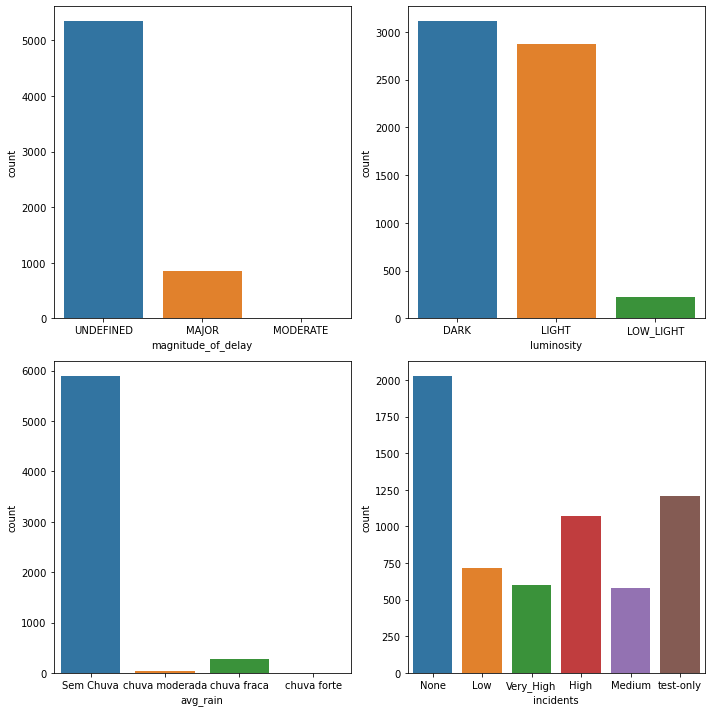

In [372]:
# Get the distribution of the non-numeric columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
for idx, column in enumerate(non_numeric_columns):
    sns.countplot(x=column, data=dataset, ax=axes[idx // 2, idx % 2])
plt.tight_layout()
plt.show()

#### Magnitude of delay / Delay in Seconds

<AxesSubplot:xlabel='incidents', ylabel='count'>

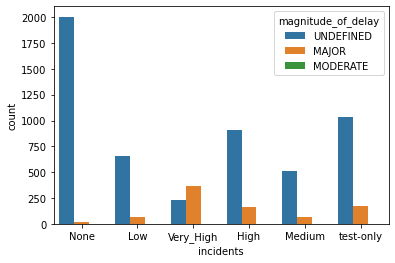

In [373]:
# Relation between "MAJOR" delays and the incidents
sns.countplot(x='incidents', hue='magnitude_of_delay', data=dataset)

Number of UNDEFINED delays: 5344
Number of MAJOR delays: 853
Number of MODERATE delays: 9


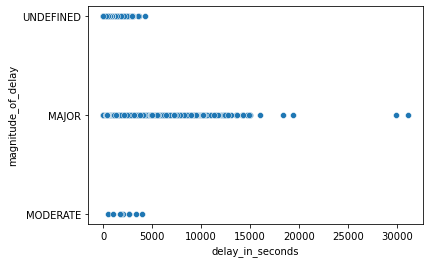

In [374]:
# Relation between magnitude of delay and delay in seconds
sns.scatterplot(x='delay_in_seconds', y='magnitude_of_delay', data=dataset)

# Count the UNDIFINED, MAJOR and MODERATE delays
print("Number of UNDEFINED delays: {}".format(dataset[dataset['magnitude_of_delay'] == 'UNDEFINED'].shape[0]))
print("Number of MAJOR delays: {}".format(dataset[dataset['magnitude_of_delay'] == 'MAJOR'].shape[0]))
print("Number of MODERATE delays: {}".format(dataset[dataset['magnitude_of_delay'] == 'MODERATE'].shape[0]))

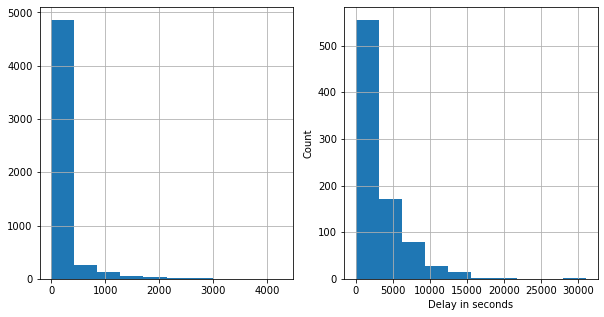

Average delay in seconds for UNDEFINED delays: 123.35778443113773
Average delay in seconds for MODERATE delays: 2182.4444444444443
Average delay in seconds for MAJOR delays: 3288.928487690504


In [375]:
# Get distribution of values of delay_in_seconds that have a magnitude_of_delay of "MAJOR" and "UNDEFINED"
undefined_delay = dataset[dataset['magnitude_of_delay'] == 'UNDEFINED']
major_delay = dataset[dataset['magnitude_of_delay'] == 'MAJOR']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
undefined_delay['delay_in_seconds'].hist(ax=axes[0])
major_delay['delay_in_seconds'].hist(ax=axes[1])
plt.xlabel('Delay in seconds')
plt.ylabel('Count')
plt.show()

# Print average delay in seconds for each magnitude of delay
print("Average delay in seconds for UNDEFINED delays: {}".format(undefined_delay['delay_in_seconds'].mean()))
print("Average delay in seconds for MODERATE delays: {}".format(dataset[dataset['magnitude_of_delay'] == 'MODERATE']['delay_in_seconds'].mean()))
print("Average delay in seconds for MAJOR delays: {}".format(major_delay['delay_in_seconds'].mean()))

In [376]:
# Get count of the incidents that have a magnitude_of_delay of "MAJOR" per type...
major_delay_zero = major_delay[major_delay['delay_in_seconds'] < 250]
print(major_delay_zero['incidents'].value_counts())

Low          32
test-only    10
None          9
Medium        2
Name: incidents, dtype: int64


Skewness (all): 6.044188264462225
Skewness (non-zero): 3.8291844458228224


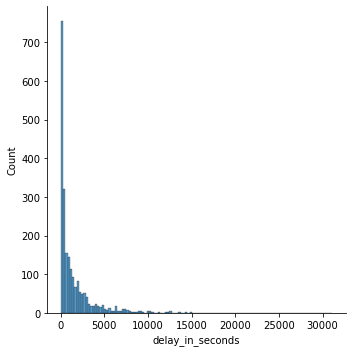

In [377]:
# Plot the distribution of the 'delay_in_seconds' column non-zero values
sns.displot(dataset[dataset['delay_in_seconds'] > 0]['delay_in_seconds'])
print("Skewness (all): {}".format(dataset['delay_in_seconds'].skew()))
print("Skewness (non-zero): {}".format(dataset[dataset['delay_in_seconds'] > 0]['delay_in_seconds'].skew()))

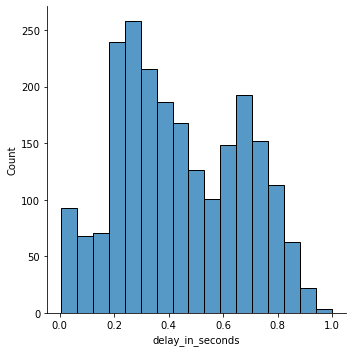

In [378]:
if 'magnitude_of_delay' in dataset.columns:
    # Map values no numeric
    dict_magnitude_of_delay = {'UNDEFINED': 1, 'MODERATE':2, 'MAJOR':3}
    dataset['magnitude_of_delay'] = dataset['magnitude_of_delay'].map(dict_magnitude_of_delay)
    
    # Multiply the 'delay_in_seconds' column by the 'magnitude_of_delay' column
    #
    # The reason for this is that the 'delay_in_seconds' column has a lot of zero values.
    # The "UNDEFINED" has a delay of 0 seconds in 75% of the cases.
    #  It has 94% of values under 10 minutes.
    #
    dataset['delay_in_seconds'] = dataset['delay_in_seconds'] * dataset['magnitude_of_delay']
    
    # Apply log transformation to the non-zero values of 'delay_in_seconds' column)
    dataset.loc[dataset['delay_in_seconds'] > 0, 'delay_in_seconds'] = np.log(dataset.loc[dataset['delay_in_seconds'] > 0, 'delay_in_seconds'])
    
    # Scale the non-zero values of 'delay_in_seconds' column
    scaler = MinMaxScaler()
    dataset.loc[dataset['delay_in_seconds'] > 0, 'delay_in_seconds'] = scaler.fit_transform(dataset.loc[dataset['delay_in_seconds'] > 0, 'delay_in_seconds'].values.reshape(-1, 1))
    
    # Plot the distribution of the non-zero values of 'delay_in_seconds' column
    sns.displot(dataset[dataset['delay_in_seconds'] > 0]['delay_in_seconds'])
    
    # Drop magnitude_of_delay column
    dataset.drop('magnitude_of_delay', axis=1, inplace=True)
    
    # Rename column as 'delay_coefficient'
    dataset.rename(columns={'delay_in_seconds': 'delay_coefficient'}, inplace=True)

#### categorizing time of day

In [379]:
# Use the hour and month value as continuous variables
# Create a binary variable for weekend or not
def create_time_variables(dataset):
    #add 2 column with the month and day from time_of_day
    dataset['month'] = pd.DatetimeIndex(dataset['record_date']).month
    dataset['day'] = pd.DatetimeIndex(dataset['record_date']).day
    return dataset


dataset = create_time_variables(dataset)

dataset.drop('record_date', axis=1, inplace=True)

<AxesSubplot:>

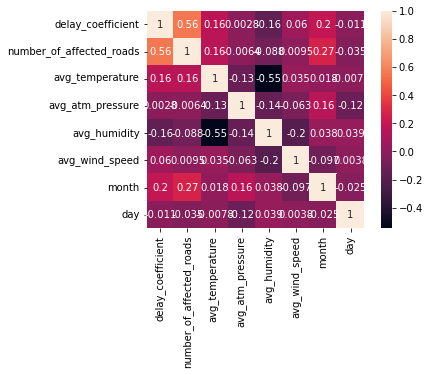

In [380]:
corr_matrix = dataset.corr()
sns.heatmap(corr_matrix,square=True, annot=True)

#### Luminosity

In [381]:
# Count different values of the 'luminosity' column
dataset['luminosity'].value_counts()

DARK         3112
LIGHT        2871
LOW_LIGHT     223
Name: luminosity, dtype: int64

None         72
High         52
test-only    37
Very_High    24
Medium       21
Low          17
Name: incidents, dtype: int64


<AxesSubplot:xlabel='luminosity', ylabel='count'>

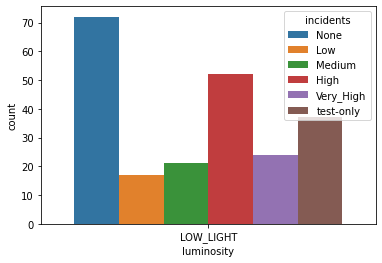

In [382]:
# Relation between LOW_LIGHT 'luminosity' and 'incidents'
low_luminosity = dataset[dataset['luminosity'] == 'LOW_LIGHT']
print(low_luminosity['incidents'].value_counts())
sns.countplot(x='luminosity', hue='incidents', data=low_luminosity)

In [383]:
# None + Low = 87
# High + Very High = 76
#
# The 'luminosity' column, when it is LOW_LIGHT, has a similar probability of having an incident or not.
# So, whenever we find a LOW_LIGHT value, we will randomly assign a value of 0 or 1.
#
def binary_luminosity(value):
    if value == 'LOW_LIGHT':
        random.seed(2023) 
        return random.randint(0, 1)
    elif value == 'DARK':
        return 0
    elif value == 'LIGHT':
        return 1
    else:
        print("ERROR: Invalid value for 'luminosity' column: {}".format(value))

def non_binary_luminosity(value):
    if value == 'DARK':
        return 0
    elif value == 'LOW_LIGHT':
        return 1
    elif value == 'LIGHT':
        return 2
    else:
        print("ERROR: Invalid value for 'luminosity' column: {}".format(value))


if 'luminosity' in dataset.columns and dataset['luminosity'].dtype == 'object':
    dataset['luminosity'] = dataset['luminosity'].apply(non_binary_luminosity)

#### Average Rain

In [384]:
# Count different values of the 'avg_rain' column.
print(dataset['avg_rain'].value_counts())

Sem Chuva         5896
chuva fraca        270
chuva moderada      35
chuva forte          5
Name: avg_rain, dtype: int64


None         67
test-only    56
High         50
Very_High    39
Low          32
Medium       26
Name: incidents, dtype: int64


<AxesSubplot:xlabel='avg_rain', ylabel='count'>

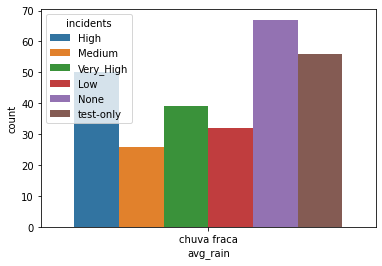

In [385]:
# Get the incidents per value of 'avg_rain'==chuva fraca
chuva_fraca = dataset[dataset['avg_rain'] == 'chuva fraca']
print(chuva_fraca['incidents'].value_counts())
sns.countplot(x='avg_rain', hue='incidents', data=chuva_fraca)

In [386]:
# Transform the 'avg_rain' column into binary values: rain/no rain
def binary_rain(value):
    if value == 'Sem Chuva':
        return 0
    else:
        return 1

def non_binary_rain(value):
    if value == 'Sem Chuva':
        return 0
    elif value == 'chuva fraca':
        return 1
    elif value == 'chuva moderada':
        return 2
    elif value == 'chuva forte':
        return 3

# Average rain
if 'avg_rain' in dataset.columns and dataset['avg_rain'].dtype == 'object':
    dataset['avg_rain'] = dataset['avg_rain'].apply(non_binary_rain)

### Handle Non-Categorical Data

#### Helper Functions

In [387]:
# Count the number of outliers per column with the IQR method; have an option to remove the outliers
def count_outliers_IQR(data, column, remove_outliers=False, verbose=False):
    # Calculate the 1st and 3rd quartile
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    # Calculate the IQR
    IQR = q3 - q1
    # Calculate the lower and upper bound
    lower_bound = q1 - (1.5 * IQR)
    upper_bound = q3 + (1.5 * IQR)
    # Count the number of outliers
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    if verbose:
        print("Number of outliers for column {} is {}".format(column, outliers.shape[0]))
    # Remove the outliers
    if remove_outliers:
        number_of_rows_before = data.shape[0]
        data = data[(data[column] > lower_bound) & (data[column] < upper_bound)]
        print("Removed {} rows from the dataset".format(number_of_rows_before - data.shape[0]))
    return data

# Count the number of outliers per column with the Z-score method; have an option to remove the outliers
def count_outliers_Z_score(data, column, remove_outliers=False, verbose=False):
    # Calculate the Z-score
    z = np.abs(stats.zscore(data[column]))
    # Count the number of outliers
    outliers = data[z > 3]
    if verbose:
        print("Number of outliers for column {} is {}".format(column, outliers.shape[0]))
    # Remove the outliers
    if remove_outliers:
        number_of_rows_before = data.shape[0]
        data = data[z < 3]
        print("Removed {} rows from the dataset".format(number_of_rows_before - data.shape[0]))
    return data

#### Average Temperature

count    6206.000000
mean       14.595875
std         4.795352
min         1.000000
25%        11.000000
50%        14.000000
75%        18.000000
max        35.000000
Name: avg_temperature, dtype: float64
Skewness: 0.5402003354292293


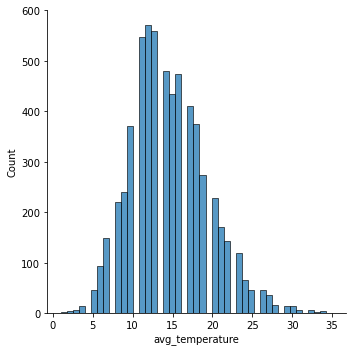

In [388]:
# Distribution of the 'avg_temperature' column
sns.displot(dataset['avg_temperature'])
print(dataset['avg_temperature'].describe())
print("Skewness: {}".format(dataset['avg_temperature'].skew()))

Number of outliers for column avg_temperature is 50
Number of outliers for column avg_temperature is 50

Outlier ceil: 28.981930577131205
Outlier floor: 0.20981934230160348
count    6206.000000
mean       14.595875
std         4.795352
min         1.000000
25%        11.000000
50%        14.000000
75%        18.000000
max        35.000000
Name: avg_temperature, dtype: float64


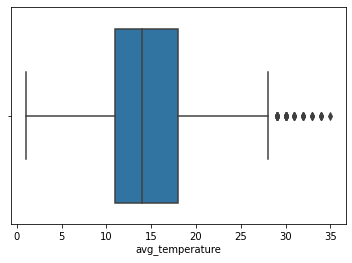

In [389]:
# Boxplot of the 'avg_temperature' column
sns.boxplot(x=dataset['avg_temperature'])

# Count the number of outliers for the 'avg_temperature' column
count_outliers_IQR(dataset, 'avg_temperature', verbose=True, remove_outliers=False)
count_outliers_Z_score(dataset, 'avg_temperature', verbose=True, remove_outliers=False)
print()

#  Get max and min values for the 'avg_temperature' column outliers using the Z-score method.
max_value = dataset['avg_temperature'].mean() + 3 * dataset['avg_temperature'].std()
min_value = dataset['avg_temperature'].mean() - 3 * dataset['avg_temperature'].std()

print("Outlier ceil: {}".format(max_value))
print("Outlier floor: {}".format(min_value))
print(dataset['avg_temperature'].describe())

None         14
Low          12
Very_High     8
test-only     7
High          7
Medium        2
Name: incidents, dtype: int64


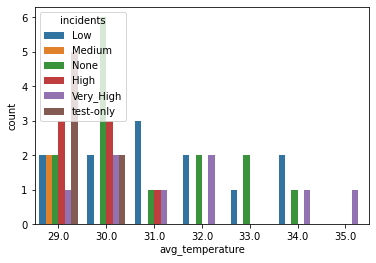

In [390]:
# Let's check the relation between the 'avg_temperature' outliers and 'incidents' (grpahically)
outliers = dataset[(dataset['avg_temperature'] > max_value)]
print(outliers['incidents'].value_counts())
sns.countplot(x='avg_temperature', hue='incidents', data=outliers)

# There are 0.008% temperature outliers. It's not a lot.
#  The temperatures are not that extreme and can be considered as valid data.
# 
# Normalize the 'avg_temperature' column
# The date is not extremely skewed, so we will use the MinMaxScaler.
scaler = MinMaxScaler()
dataset['avg_temperature'] = scaler.fit_transform(dataset['avg_temperature'].values.reshape(-1, 1))

#### Average Humidity

count    6206.000000
mean       74.340477
std        17.204386
min         6.000000
25%        63.000000
50%        78.000000
75%        90.000000
max       100.000000
Name: avg_humidity, dtype: float64
Skewness: -0.7492086582905623


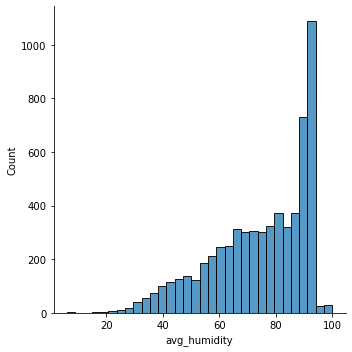

In [391]:
# Distribution of the 'avg_humidity' column
sns.displot(dataset['avg_humidity'])
print(dataset['avg_humidity'].describe())
print("Skewness: {}".format(dataset['avg_humidity'].skew()))

Number of outliers for column avg_humidity is 11
Number of outliers for column avg_humidity is 11

3200     6.0
3639     7.0
716      7.0
2999     8.0
3245     8.0
267     17.0
2973    17.0
4743    17.0
4646    18.0
402     20.0
4182    21.0
Name: avg_humidity, dtype: float64


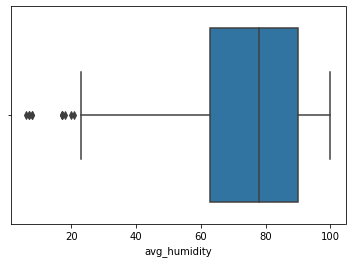

In [392]:
# Boxplot of the 'avg_humidity' column
sns.boxplot(x=dataset['avg_humidity'])

# Count the number of outliers for the 'avg_humidity' column
count_outliers_IQR(dataset, 'avg_humidity', verbose=True, remove_outliers=False)
count_outliers_Z_score(dataset, 'avg_humidity', verbose=True, remove_outliers=False)
print()

# Get 11 most small values for the 'avg_humidity' column.
print(dataset['avg_humidity'].nsmallest(11))

# Since the 'avg_humidity' column has a very reduced number of outliers, we will remove them.
# Also, these values are not representative and occur only in specific circumstances.
# For instance, the average humidity in the shaara desert is 25%.
# In the antarctic, humidity is sometimes close to 0%.
# But apparently, in Guimarães, the humidity can have values as low as 6.0%.
dataset = count_outliers_IQR(dataset, 'avg_humidity', verbose=False, remove_outliers=False)

# Normalize the 'avg_humidity' column
scaler = MinMaxScaler()
dataset['avg_humidity'] = scaler.fit_transform(dataset['avg_humidity'].values.reshape(-1, 1))

#### Average Wind Speed

count    6206.000000
mean        1.268853
std         1.283545
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: avg_wind_speed, dtype: float64
Skewness: 1.3817984915729273


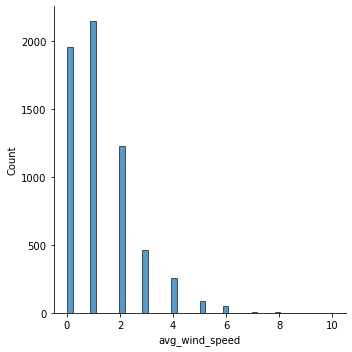

In [393]:
# Distribution of the 'avg_wind_speed' column
sns.displot(dataset['avg_wind_speed'])
print(dataset['avg_wind_speed'].describe())
print("Skewness: {}".format(dataset['avg_wind_speed'].skew()))

Number of outliers for column avg_wind_speed is 63
Number of outliers for column avg_wind_speed is 63



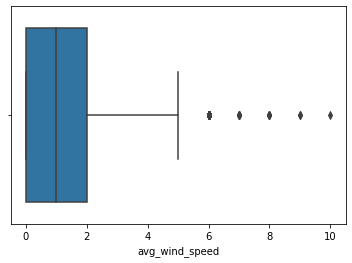

In [394]:
# Boxplot of the 'avg_wind_speed' column
sns.boxplot(x=dataset['avg_wind_speed'])

# Count the number of outliers for the 'avg_wind_speed' column
count_outliers_IQR(dataset, 'avg_wind_speed', verbose=True, remove_outliers=False)
count_outliers_Z_score(dataset, 'avg_wind_speed', verbose=True, remove_outliers=False)
print()

# With this number of outliers, we will do nothing.
# The values are not that extreme and can be considered as valid data.
#
# Since the data is not normally distributed, and is skewed to the right
#  we will use a scaler that is not sensitive to outliers/normal distribution.
#scaler = PowerTransformer()
#dataset['avg_wind_speed'] = scaler.fit_transform(dataset['avg_wind_speed'].values.reshape(-1, 1))

# Now that the data is more normally distributed, we can use the MinMaxScaler.
scaler = MinMaxScaler()
dataset['avg_wind_speed'] = scaler.fit_transform(dataset['avg_wind_speed'].values.reshape(-1, 1))

#### Average Pressure

count    6206.000000
mean     1018.121656
std         5.206504
min       997.000000
25%      1015.000000
50%      1019.000000
75%      1022.000000
max      1032.000000
Name: avg_atm_pressure, dtype: float64
Skewness: -0.410711923939691


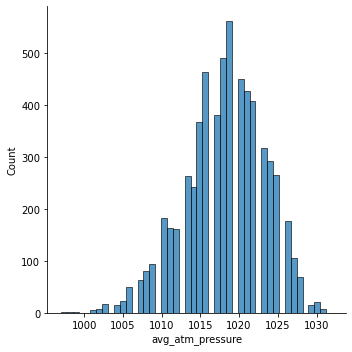

In [395]:
# Distribution of the 'avg_atm_pressure' column
sns.displot(dataset['avg_atm_pressure'])
print(dataset['avg_atm_pressure'].describe())
print("Skewness: {}".format(dataset['avg_atm_pressure'].skew()))

Number of outliers for column avg_atm_pressure is 57
Number of outliers for column avg_atm_pressure is 22


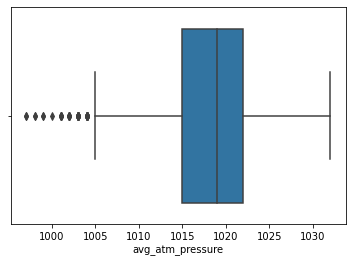

In [396]:
# Boxplot of the 'avg_atm_pressure' column
sns.boxplot(x=dataset['avg_atm_pressure'])

# Count the number of outliers for the 'avg_atm_pressure' column
count_outliers_IQR(dataset, 'avg_atm_pressure', verbose=True, remove_outliers=False)
count_outliers_Z_score(dataset, 'avg_atm_pressure', verbose=True, remove_outliers=False)

# The minimum value of 997 is not an abnormal value for the atmospheric pressure.
# Since there are not many outliers, we will not remove them.
# Also, the values are not that extreme and can be considered as valid data.
#
# Let's normalize the 'avg_atm_pressure' column
scaler = MinMaxScaler()
dataset['avg_atm_pressure'] = scaler.fit_transform(dataset['avg_atm_pressure'].values.reshape(-1, 1))

<AxesSubplot:>

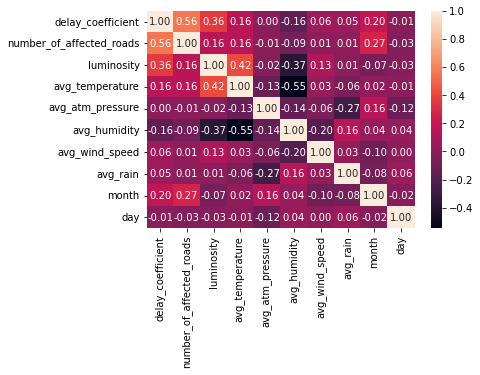

In [397]:
sns.heatmap(dataset.corr(), annot=True, fmt='.2f')

## 5. Models Training

In [398]:
results_table = []
results_dict = []

#### Helper Functions

In [399]:
""" Save results to a file. """
def saveResults ( results, path ):
    file = open("results/" + path, 'w')
    file.write ("RowId,Incidents\n")
    i = 1
    for result in results :
        file.write (str(i) + "," + result + "\n")
        i += 1

In [400]:
def printOrWrite(model_name, predictions, results, results_to_test):
    if results_to_test:
        classification = metrics.classification_report(results, predictions, zero_division=0)
        results_table.append({'model': model_name, 'table': classification})
        classification_dict = metrics.classification_report(results, predictions, output_dict=True, zero_division=0)
        results_dict.append({
            'model': model_name,
            'accuracy': classification_dict['accuracy'],
            'precision': classification_dict['macro avg']['precision'],
            'recall': classification_dict['macro avg']['recall'],
            'f1-score': classification_dict['macro avg']['f1-score'],
            })
        print(model_name, " Accuracy: ", metrics.accuracy_score(predictions, results))
    else:
        saveResults(predictions, model_name + '.csv')

#### Splitting the dataset

In [401]:
# run for test or run for submission
results_to_test = True

# Copy the dataset
train_df = dataset.copy()
test_df = dataset.copy()

# Filter the train and test data
# Train data has the 'incidents' column value != 'test-only'
# Test data has the 'incidents' column value == 'test-only'
train_df = train_df[train_df['incidents'] != 'test-only']
test_df = test_df[test_df['incidents'] == 'test-only']
test_df.drop('incidents', axis=1, inplace=True)

incidents = train_df['incidents'].copy()

if results_to_test:
    y = incidents
    x = train_df.drop(['incidents'], axis=1)
    x_training, x_testing, y_training, y_testing = model_selection.train_test_split(x, y, test_size=0.3, random_state=2022)

else:
    x_training = train_df.drop(['incidents'], axis=1)
    y_training = incidents
    x_testing = test_df
    y_testing = None

### 5.1 Árvores de Decisão e Classificação

In [402]:
dtc = tree.DecisionTreeClassifier(random_state=2023, criterion="gini")
dtc.fit(x_training,y_training)
decision_trees_predictions = dtc.predict(x_testing)

printOrWrite("DecisionTrees", decision_trees_predictions, y_testing, results_to_test)

DecisionTrees  Accuracy:  0.9046666666666666


### 5.2 RandomForestClassifier

In [403]:
random_forest = RandomForestClassifier(random_state=2023, n_estimators=600, criterion="gini",warm_start=True)
random_forest.fit(x_training, y_training)
random_forest_predictions = random_forest.predict(x_testing)

printOrWrite("RandomForest", random_forest_predictions, y_testing, results_to_test)

RandomForest  Accuracy:  0.9133333333333333


### 5.3 Regressão Logística

In [404]:
logmodel = linear_model.LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
logmodel.fit(x_training,y_training)
logistic_regression_predictions = logmodel.predict(x_testing)

printOrWrite("LogisticRegression", logistic_regression_predictions, y_testing, results_to_test)

LogisticRegression  Accuracy:  0.6033333333333334


### 5.4 SVC

In [405]:
model = SVC(random_state=2023)
model.fit(x_training, y_training)
hold_out_predictions = model.predict(x_testing)

printOrWrite("SVC", hold_out_predictions, y_testing, results_to_test)

SVC  Accuracy:  0.548


### 5.6 KNeighborsClassifier

In [406]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_training, y_training)
knn_predictions = knn.predict(x_testing)

printOrWrite("KNN", knn_predictions, y_testing, results_to_test)

KNN  Accuracy:  0.746


### 5.7 MLPClassifier

In [407]:
mlpclass = MLPClassifier(alpha=1, max_iter=1000)
mlpclass.fit(x_training, y_training)
mlpclass_predictions = mlpclass.predict(x_testing)

printOrWrite("MLPClassifier", mlpclass_predictions, y_testing, results_to_test)

MLPClassifier  Accuracy:  0.7013333333333334


### 5.8 AdaBoostClassifier

In [408]:
adaBoost = AdaBoostClassifier(n_estimators=100, random_state=2023)
adaBoost.fit(x_training, y_training)
adaBoost_predictions = adaBoost.predict(x_testing)

printOrWrite("AdaBoost", adaBoost_predictions, y_testing, results_to_test)

AdaBoost  Accuracy:  0.7506666666666667


### 5.9 GaussianNB

In [409]:
gaussianNB = GaussianNB()
gaussianNB.fit(x_training, y_training)
gaussianNB_predictions = gaussianNB.predict(x_testing)

printOrWrite("GaussianNB", gaussianNB_predictions, y_testing, results_to_test)

GaussianNB  Accuracy:  0.5666666666666667


### 5.10 QuadraticDiscriminantAnalysis

In [410]:
quadraticDiscriminantAnalysis = QuadraticDiscriminantAnalysis()
quadraticDiscriminantAnalysis.fit(x_training, y_training)
quadraticDiscriminantAnalysis_predictions = quadraticDiscriminantAnalysis.predict(x_testing)

printOrWrite("QuadraticDiscriminantAnalysis", quadraticDiscriminantAnalysis_predictions, y_testing, results_to_test)

QuadraticDiscriminantAnalysis  Accuracy:  0.63


### 5.11 GaussianProcessClassifier

In [411]:
gaussian = GaussianProcessClassifier(n_restarts_optimizer=3, max_iter_predict=100, random_state=2023)
gaussian.fit(x_training, y_training)
gaussian_predictions = gaussian.predict(x_testing)

printOrWrite("GaussianProcessClassifier", gaussian_predictions, y_testing, results_to_test)

GaussianProcessClassifier  Accuracy:  0.7246666666666667


### 5.12 Maquinas de Vectores de Suporte (SVM)

In [412]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}
grid = GridSearchCV(SVC(random_state=2022), param_grid, refit=True, verbose=3)
grid.fit(x_training, y_training)
grid_predictions = grid.predict(x_testing)

printOrWrite("GridSearchCV", grid_predictions, y_testing, results_to_test)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.433 total time=   0.7s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.446 total time=   0.7s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.437 total time=   0.7s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.443 total time=   0.7s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.453 total time=   0.7s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.579 total time=   0.5s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.569 total time=   0.5s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.564 total time=   0.5s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.567 total time=   0.5s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.573 total time=   0.5s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.441 total time=   0.5s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [421]:
df_feat = pd.DataFrame(x_training, columns=x_training.columns)
df_target = pd.DataFrame(y_training, columns=['incidents'])
# 10-Fold Cross Validation
cross_valid_model = SVC(random_state=2022)
cross_val_score(cross_valid_model, df_feat, np.ravel(df_target), cv=10)

printOrWrite("CrossValidation", grid_predictions, y_testing, results_to_test)

CrossValidation  Accuracy:  0.8546666666666667


### 5.13 Neural Network

In [422]:
# Data: x_training, x_testing, y_training, y_testing
#
# Encode the labels
encoder = LabelEncoder()  
y_training_labeled = encoder.fit_transform(y_training)
y_training_labeled = tf.keras.utils.to_categorical(y_training_labeled)

# If the submission is for kaggle, y_testing does not exist.
# Otherwise, we need to encode the labels.
if results_to_test:
    y_testing_labeled = encoder.fit_transform(y_testing)
    y_testing_labeled = tf.keras.utils.to_categorical(y_testing_labeled)

# Define the model
model = tf.keras.Sequential()

# Add a hidden layer with 16 units and ReLU activation
model.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(x_training.shape[1],)))

# Add a hidden layer with 32 units and ReLU activation
model.add(tf.keras.layers.Dense(32, activation='relu'))

# Add a hidden layer with 64 units and ReLU activation
model.add(tf.keras.layers.Dense(64, activation='relu'))

# Add a hidden layer with 64 units and ReLU activation
model.add(tf.keras.layers.Dense(64, activation='relu'))

# Add a hidden layer with 32 units and ReLU activation
model.add(tf.keras.layers.Dense(32, activation='relu'))

# Add a hidden layer with 16 units and ReLU activation
model.add(tf.keras.layers.Dense(16, activation='relu'))

# Add an output layer with 5 units and softmax activation
model.add(tf.keras.layers.Dense(5, activation='softmax'))

# Compile the model with categorical crossentropy loss and an Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model to the training data
history = model.fit(x_training, y_training_labeled, epochs=200, batch_size=32, validation_split=0.1)

# Evaluate the model on the test data
if results_to_test:
    loss, accuracy = model.evaluate(x_testing, y_testing_labeled)
    print("Neural Network Accuracy: ", accuracy)
else:
    predictions = model.predict(x_testing)

    results = tf.argmax(predictions, axis=1)
    results = encoder.inverse_transform(results)
    printOrWrite("NeuralNetwork", results, y_testing, results_to_test)

Epoch 1/200
99/99 [==============================] - 1s 5ms/step - loss: 1.4087 - accuracy: 0.4111 - val_loss: 1.3576 - val_accuracy: 0.4486
Epoch 2/200
99/99 [==============================] - 0s 2ms/step - loss: 1.2918 - accuracy: 0.4781 - val_loss: 1.2640 - val_accuracy: 0.5286
Epoch 3/200
99/99 [==============================] - 0s 3ms/step - loss: 1.1882 - accuracy: 0.5384 - val_loss: 1.2025 - val_accuracy: 0.5429
Epoch 4/200
99/99 [==============================] - 0s 3ms/step - loss: 1.1013 - accuracy: 0.5803 - val_loss: 1.1792 - val_accuracy: 0.5600
Epoch 5/200
99/99 [==============================] - 0s 3ms/step - loss: 1.0415 - accuracy: 0.5911 - val_loss: 1.0111 - val_accuracy: 0.6086
Epoch 6/200
99/99 [==============================] - 0s 2ms/step - loss: 1.0068 - accuracy: 0.6067 - val_loss: 0.9734 - val_accuracy: 0.6771
Epoch 7/200
99/99 [==============================] - 0s 2ms/step - loss: 0.9670 - accuracy: 0.6143 - val_loss: 0.9295 - val_accuracy: 0.6600
Epoch 8/200
9

### 5.14 XGBClassifier

In [423]:
tryoutparams = False

# {'learning_rate': 0.01, 'max_depth': 15, 'n_estimators': 1000, 'tree_method': 'gpu_hist'} 0.9184000000000001
# {'learning_rate': 0.005, 'max_depth': 15, 'n_estimators': 1500, 'tree_method': 'gpu_hist'} 0.9194000000000001

if tryoutparams:
    param_grid = {
    'n_estimators': [1500, 1000],
    'max_depth': [10],
    'learning_rate': [0.01, 0.005],
    'tree_method': ['gpu_hist', 'hist']
    }

    xgbclassifier_set = dataset.copy()
    xgbclassifier_set = xgbclassifier_set[xgbclassifier_set['incidents'] != 'test-only']
    xgbclassifier_set_x = xgbclassifier_set.drop(['incidents'], axis=1)
    xgbclassifier_set_y = xgbclassifier_set['incidents']

    encoder = LabelEncoder()  
    y_training_labeled = encoder.fit_transform(xgbclassifier_set_y)

    # fit model no training data
    xgbclassifier = xgb.XGBClassifier(
        random_state=2023,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    # change cv later? use square root of dataset size ?
    grid_search = GridSearchCV(estimator=xgbclassifier, param_grid=param_grid, cv=5, verbose=3)
    grid_search.fit(xgbclassifier_set_x, y_training_labeled)
    print(grid_search.best_params_)
    print(grid_search.best_score_)
else:
    encoder = LabelEncoder()  
    y_training_labeled = encoder.fit_transform(y_training)
    
    # fit model no training data
    xgbclassifier = xgb.XGBClassifier(
        booster='gbtree',
        random_state=2023,
        use_label_encoder=False,
        eval_metric='mlogloss',
        tree_method='gpu_hist',
        n_estimators=300,
        learning_rate=0.2,
        max_depth=15,
    )

    xgbclassifier.fit(x_training, y_training_labeled)
    xgbclassifier_predictions = xgbclassifier.predict(x_testing)

    results = encoder.inverse_transform(xgbclassifier_predictions)
    printOrWrite("XGBClassifier", results, y_testing, results_to_test)

XGBClassifier  Accuracy:  0.9253333333333333


## 6. Model Evaluation

In [431]:
results_plot = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])
for row in results_dict:
    results_plot = results_plot.append({
        'Model': row['model'],
        'Accuracy': row['accuracy'],
        'Precision': row['precision'],
        'Recall': row['recall'],
        'F1-Score': row['f1-score']
        }, ignore_index=True)

(0.0, 1.0)

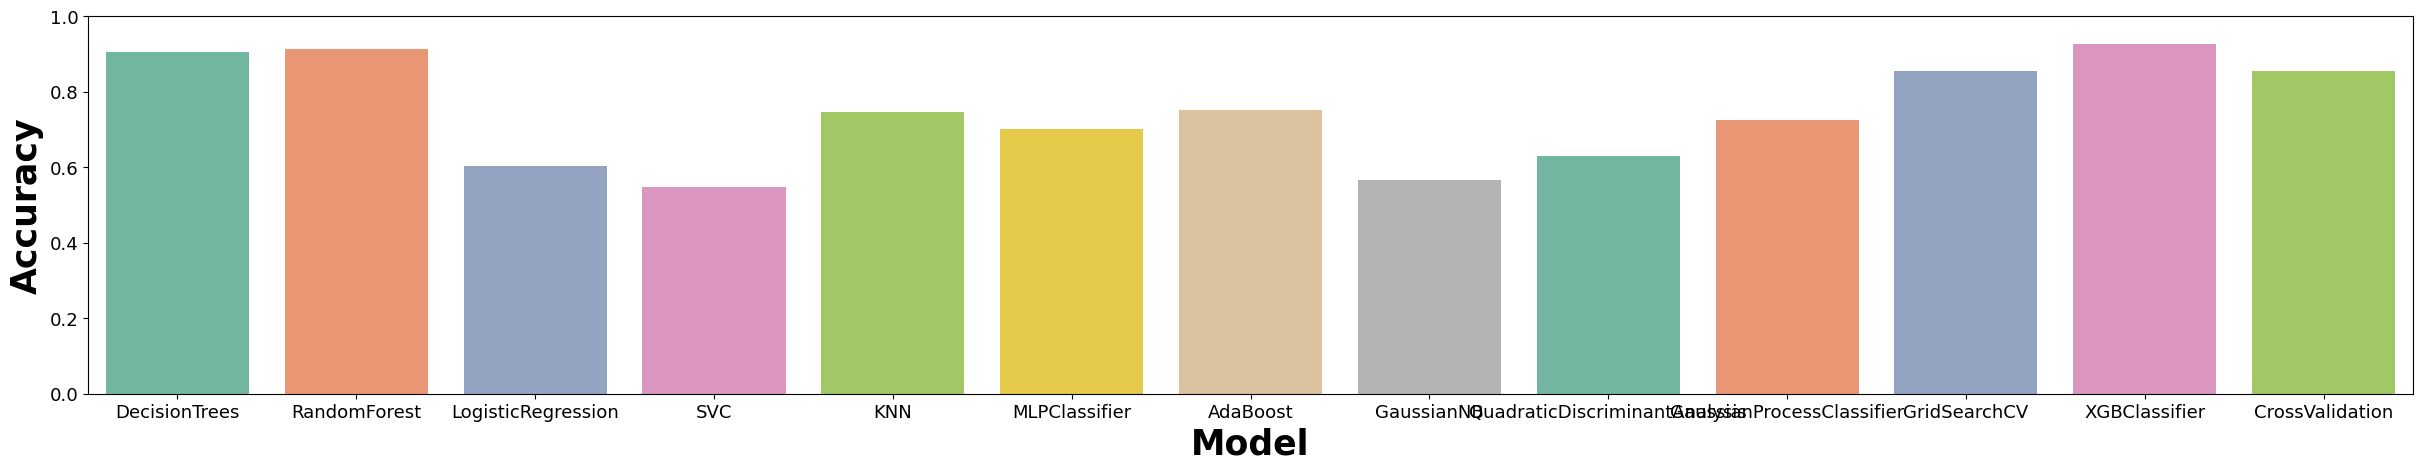

In [454]:
fig, ax = plt.subplots(figsize=(30, 5), dpi=100)
plt.rc('font', size=13)
sns.barplot(x=results_plot['Model'] , y=results_plot['Accuracy'], ax=ax, palette='Set2')
ax.set_xlabel('Model', fontdict={'color':'black', 'weight':'bold', 'size': 25})
ax.set_ylabel('Accuracy', fontdict={'color':'black', 'weight':'bold', 'size': 25})
ax.set_ylim(0, 1)

Text(0, 0.5, 'Precision')

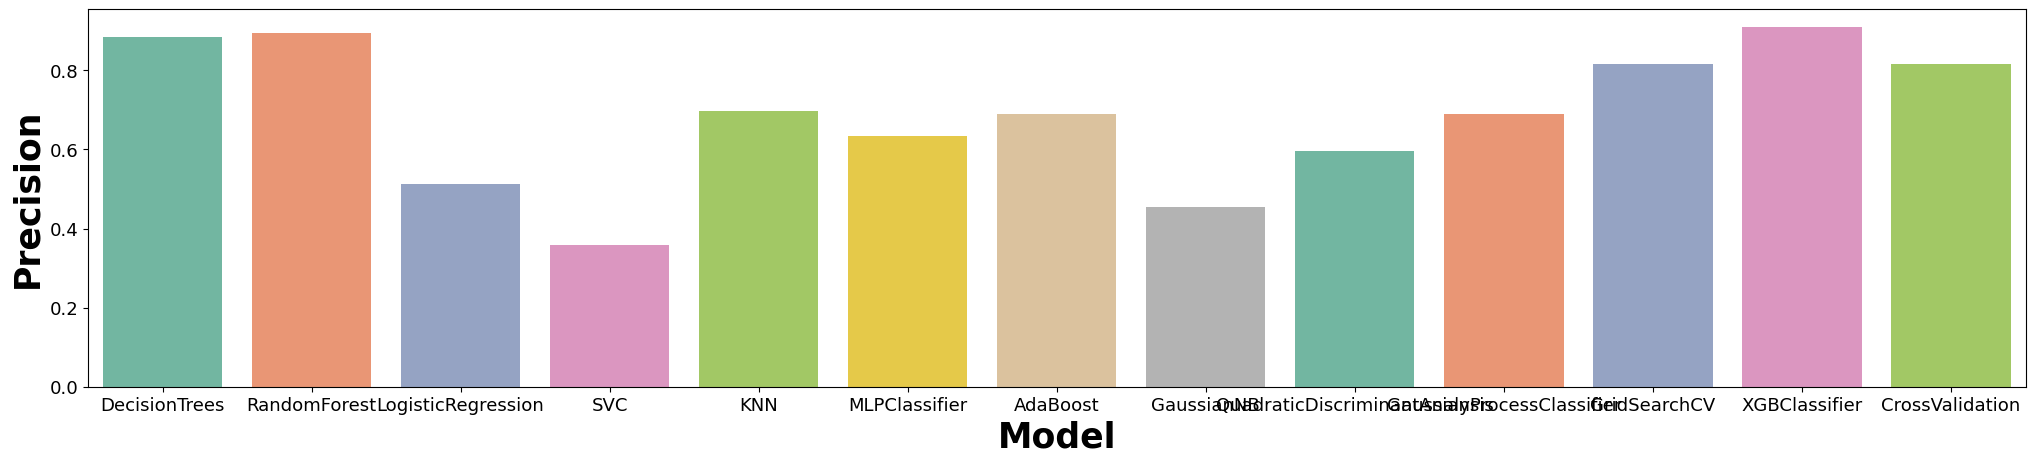

In [455]:
fig, ax = plt.subplots(figsize=(25, 5), dpi=100)
sns.barplot(x=results_plot['Model'] , y=results_plot['Precision'], ax=ax, palette='Set2')
ax.set_xlabel('Model', fontdict={'color':'black', 'weight':'bold', 'size': 25})
ax.set_ylabel('Precision', fontdict={'color':'black', 'weight':'bold', 'size': 25})

Text(0, 0.5, 'Recall')

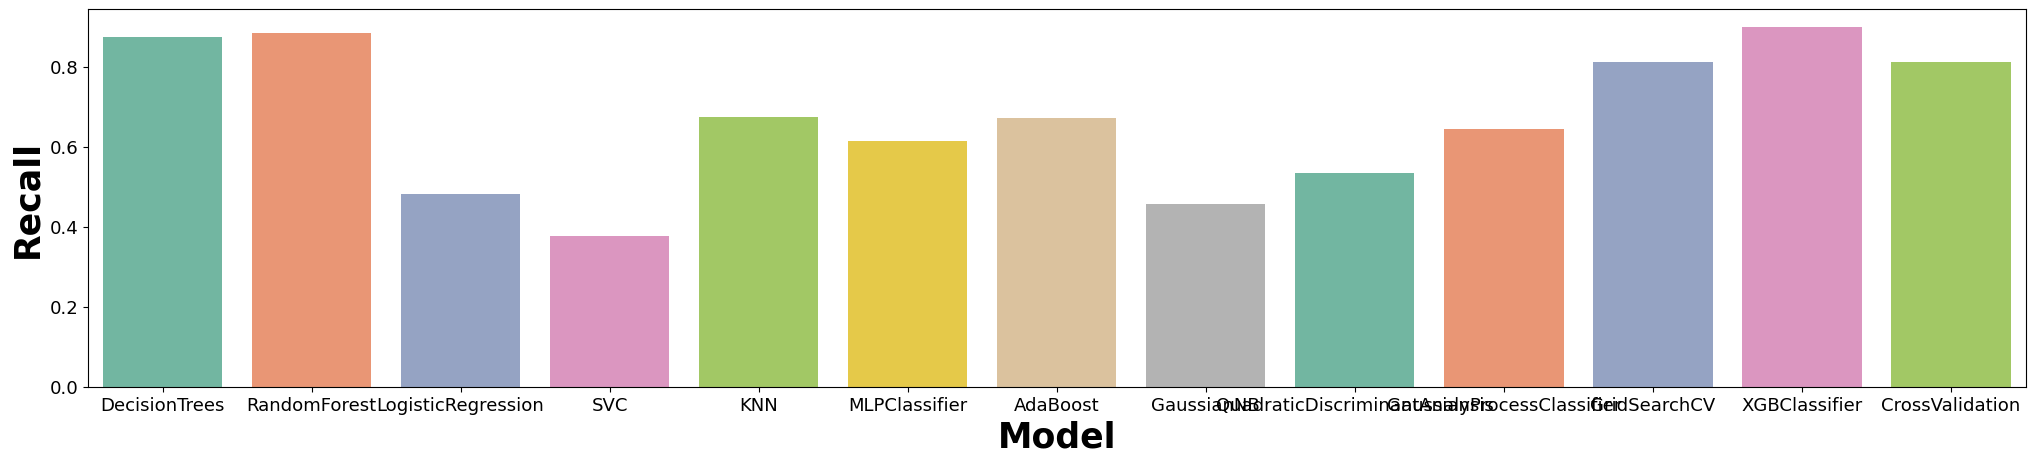

In [456]:
fig, ax = plt.subplots(figsize=(25, 5), dpi=100)
sns.barplot(x=results_plot['Model'] , y=results_plot['Recall'], ax=ax, palette='Set2')
ax.set_xlabel('Model', fontdict={'color':'black', 'weight':'bold', 'size': 25})
ax.set_ylabel('Recall', fontdict={'color':'black', 'weight':'bold', 'size': 25})

Text(0, 0.5, 'F1-Score')

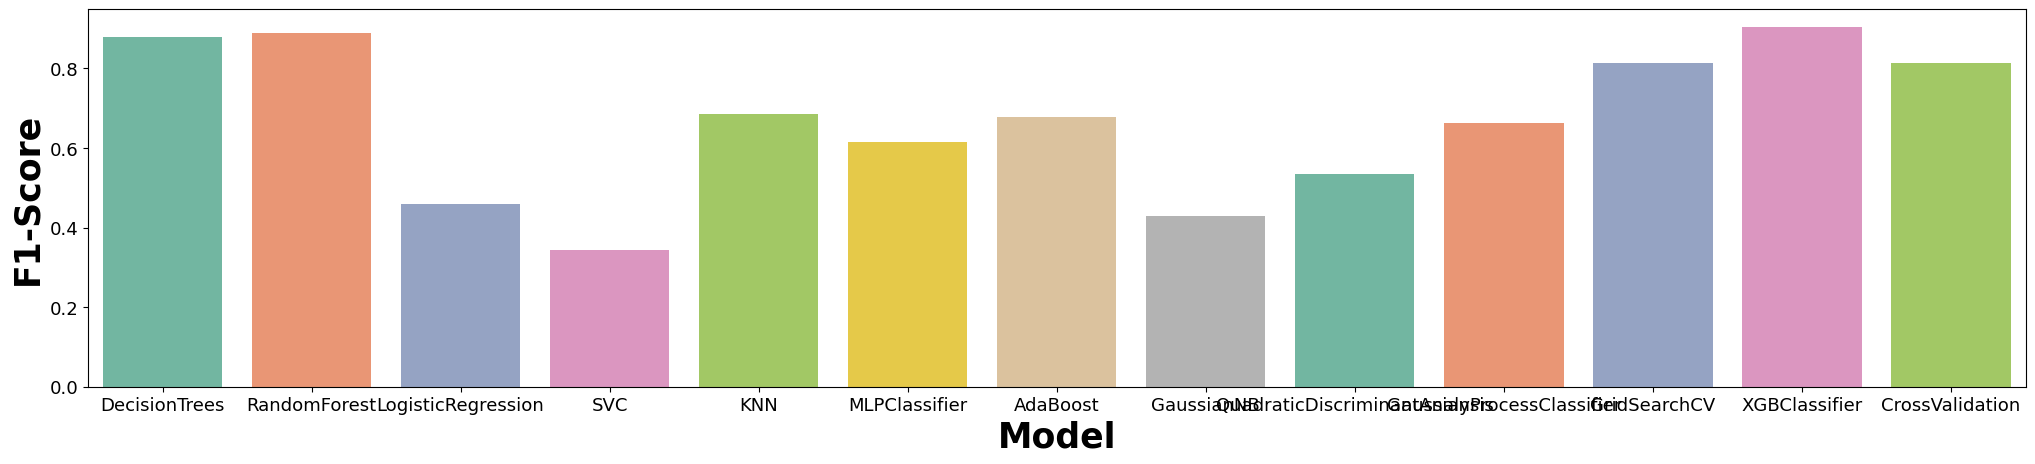

In [457]:
fig, ax = plt.subplots(figsize=(25, 5), dpi=100)
sns.barplot(x=results_plot['Model'] , y=results_plot['F1-Score'], ax=ax, palette='Set2')
ax.set_xlabel('Model', fontdict={'color':'black', 'weight':'bold', 'size': 25})
ax.set_ylabel('F1-Score', fontdict={'color':'black', 'weight':'bold', 'size': 25})